In [11]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from evaluation import evaluate
from synthetic_data_generator import synthetic_data_generator
from src.algorithms.dagmm import DAGMM
from src.algorithms import RecurrentEBM
from src.algorithms import LSTMAD

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [12]:
def binary_label(pred, threshold = None):
    if threshold == None:
        threshold = np.mean(pred) + 2*np.std(pred)
    return np.where(pred >= threshold, 1, 0)

In [13]:
def plot_scores(X_test, y_test, pred, scale_factor, threshold = None):
    if threshold:
        threshold_line = len(X_test) * [threshold]
    else:
        threshold_line = len(X_test) * [np.mean(pred) + 2*np.std(pred)]
    plt.subplot(211)
    for col in X_test.columns:
        plt.plot(X_test[col], color="black")
    plt.subplot(212)
    plt.plot(np.arange(len(X_test)), [x/scale_factor for x in pred])
    plt.plot([x/scale_factor for x in threshold_line])
    for anomaly in y_test:
        plt.axvspan(anomaly - 1, anomaly + 1, facecolor='g', alpha=0.5)
    plt.legend()
    plt.title('Reconstruction error')
    plt.show()

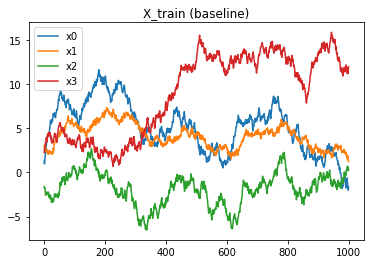

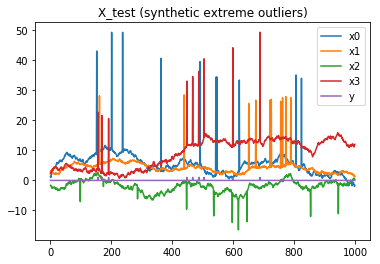

100%|██████████| 15/15 [00:06<00:00,  2.77it/s]


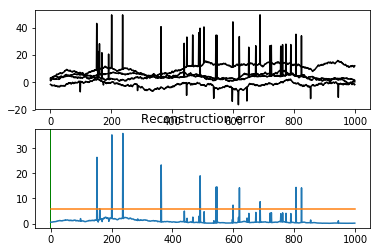

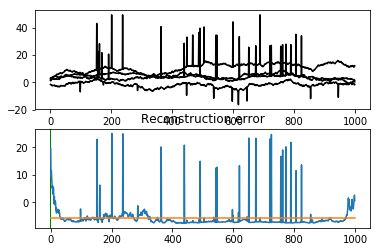

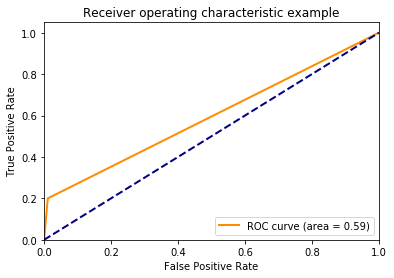

            name  accuracy  precision  recall  F1-score
0  Recurrent EBM     0.981   0.153846     0.2  0.173913


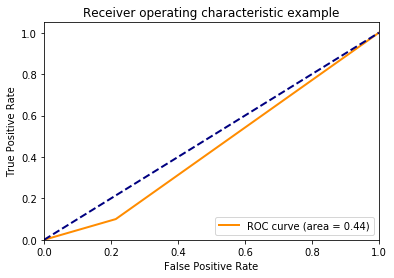

            name  accuracy  precision  recall  F1-score
0  Recurrent EBM     0.981   0.153846     0.2  0.173913
1          DAGMM     0.779   0.004695     0.1  0.008969


In [15]:
def main():
    data_generator = synthetic_data_generator()
    X_train, y_train, X_test, y_test = data_generator.generate_outliers("extreme")
    
    y_binary = [] # predicted binary labels of all models
    y_scores = [] # error measures of each prediction
    
    ReEBM = RecurrentEBM(num_epochs=15)
    ReEBM.fit(X_train, None)
    ReEBM_scores = ReEBM.predict(X_test)
    ReEBM_binary = binary_label(ReEBM_scores)
    y_binary.append(ReEBM_binary)
    plot_scores(X_test, y_test, ReEBM_scores, 100)
    
    dagmm = DAGMM()
    dagmm.fit(X_train.values, y_train)
    dagmm_binary, dagmm_scores, dagmm_threshold = dagmm.predict(X_test.values)
    y_binary.append(dagmm_binary)
    plot_scores(X_test, y_test, dagmm_scores, 1, dagmm_threshold)
    
    #lstmad = LSTMAD()
    #lstmad.fit(X_train.values, None)
    #lstmad_scores = lstmad.predict(X_test.values)
    #lstmad_binary = binary_label(lstmad_scores, 0)
    #y_binary.append(lstmad_binary)
    #plot_scores(X_test, y_test, lstmad_scores, 2, 0)
    
    working_models = ["Recurrent EBM", "DAGMM"]#, "LSTM-AD"]
    evaluate(y_test.values, y_binary, working_models)

if __name__ == '__main__':
    main()